
- Column1: Device ID
- Column2: accelerometer x
- Column3: accelerometer y
- Column4: accelerometer z
- Column5: gyroscope x
- Column6: gyroscope y
- Column7: gyroscope z
- Column8: magnetometer x
- Column9: magnetometer y
- Column10: magnetometer z
- Column11: Timestamp
- Column12: Activity Label (16 atividades)


In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ReliefF import ReliefF
from sklearn.feature_selection import SelectKBest, chi2

import mainActivity

# 2. Carregamento e preparação dos dados

In [8]:
window = 20 # TODO tirar isto daqui
loc = []

for i in range (0,15):
    loc.append("FORTH_TRACE_DATASET-master/part" + str(i) + "/part" + str(i) + "dev2.csv")

array = []
for file in loc:
    df = pd.read_csv(file, sep=',', header=None)
    print(df.shape)
    array.append(df.to_numpy())

array = np.concatenate(array)
print(array.shape)

(52864, 12)
(53376, 12)
(53248, 12)
(53247, 12)
(52992, 12)
(52864, 12)
(53631, 12)
(52480, 12)
(44288, 12)
(50432, 12)
(49664, 12)
(52864, 12)
(53120, 12)
(53504, 12)
(53248, 12)
(781822, 12)


# 3. Análise e tratamento de *Outliers*

In [9]:

t_acc = np.sqrt(np.add(np.square(array[:,1]),
                       np.square(array[:,2]),
                       np.square(array[:,3])))

t_gyr = np.sqrt(np.add(np.square(array[:,4]),
                       np.square(array[:,5]),
                       np.square(array[:,6])))

t_mag = np.sqrt(np.add(np.square(array[:,7]),
                       np.square(array[:,8]),
                       np.square(array[:,9])))

        

## 3.1 boxplot de cada atividade

<Figure size 432x288 with 0 Axes>

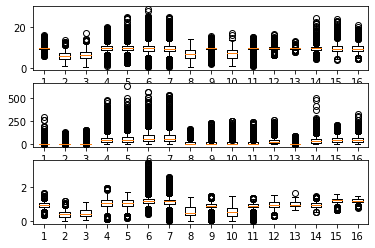

In [10]:

# act1 = t_acc[array[:,-1]==5]
activities = np.arange(1, 17) 
box_acc = [] # TODO ver se dá para fazer isto com np.array
box_gyr = []
box_mag = []
for i in range(1,17):
    act = (array[:,-1]==i)
    #length = np.sum(act)
    box_acc.append(t_acc[act]) # TODO outra forma?
    box_gyr.append(t_gyr[act])
    box_mag.append(t_mag[act])

#box_acc = np.array(box_acc)
plt.figure()
fig, axs = plt.subplots(3)
axs[0].boxplot(box_acc)
axs[1].boxplot(box_gyr)
axs[2].boxplot(box_mag)
plt.show()

In [11]:
zscores = mainActivity.zscore(t_acc)
zscores.shape

(781822,)

In [12]:

# desvio e outliers para cada k = 3, 3.5, 4
d = np.empty(shape=[3,16])
outliersk = np.empty(shape=[])
x_density = 5 # percentage

# iterar pelos modulos e, depois, por cada atividade
for box in ([box_acc, box_gyr, box_mag]):
    for i in range(16):
        # computar os quartis e definir os limites
        q1 = np.quantile(box[:][i], 0.25)
        q3 = np.quantile(box[:][i], 0.75)
        iqr = q3-q1 # interquartile range
        upper_bound = q3+(1.5*iqr)
        lower_bound = q1-(1.5*iqr)

        # receber os outliers e a matrix de indices dos mesmos
        outliers = box[:][i][(box[:][i] <= lower_bound) | (box[:][i] >= upper_bound)]
        out_bool = (box[:][i] <= lower_bound) | (box[:][i] >= upper_bound)
        box[:][i] = box[:][i][(box[:][i] >= lower_bound) & (box[:][i] <= upper_bound)]
        
        #unique, counts = np.unique(out_bool, return_counts=True)
        #desvios
        counts = np.count_nonzero(out_bool==True)
        d.append((counts/out_bool.size)*100) # TODO se a coluna nao tiver desvios
        
        # TODO breakar aqui provavelmente, ler melhor se e mesmo para
        # implementar o z-score a cada coluna
        zscore = stats.zscore(box[:][i], axis=0, ddof=0, nan_policy='propagate')
        outliersk.append(box[:][i][(zscore <= -3) | (zscore >= 3)])
        #print('The following are the outliers from the z-score test: {}'.format(outliersk[:][i]))
        
        #iterar para cada coluna
        centroids, cluster = mainActivity.k_means(box[:][i], 3)


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
t_out, td = mainActivity.get_outliers(t_acc)
p = t_out.shape[0]
acc_out = mainActivity.inject_outliers(10, 4, t_out, p)
# os valores mudam mesmo apesar do teste as array dar igual

In [ ]:
coef = []
for vec in box_acc:
    
    n = vec.size    
    ran = np.ptp(vec)
    test = np.random.rand(n)*ran
    #print(np.reshape(test[:n], (-1,1)))
    #print(np.reshape(vec[:n], (-1,1)).shape)
    test = np.append(test[:n], test[:n]).reshape(-1, 2)
    coef.append(mainActivity.fit_linear(test, vec, n))



In [ ]:

for i in range(16):
    stats.kstest(box_acc[:][i], 'norm') # if follows a gaussian


**Features**

No artigo em causa, as features estatísticas direcionam-se apenas a cada eixo do acelerómetro e do giroscópio (colunas 1-7)

Damos também uso A estratégia 'sliding window' para atuar em todo o array de forma contínua

In [ ]:
mean = mainActivity.mean(array[:,1:7], window)
median = mainActivity.median(array[:,1:7], window)
std, var = mainActivity.std_var(array[:,1:7], window)
rms = mainActivity.rms(array[:,1:7], window)
irange = mainActivity.irange(array[:,1:7], window)

ai, vi = mainActivity.mov_intensity(array[:,1:4], window)
sma = mainActivity.sma(array[:,1:4], window)

ai.shape
feat_array = np.concatenate((mean, median, std, var, rms, irange), \
    axis=1)

In [ ]:
x = array[:,1:10]
y = array[:,-1]
print(x.shape, y.shape)

(52864, 9) (52864,)


In [ ]:
x = array[:,1:10]
y = array[:,-1]

pca, X_train, X_test, y_train, y_test = mainActivity.pca_feature(x, y, 0.5)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
var = pca.explained_variance_ratio_
print(var)

[0.4461576  0.16315734 0.15262067 0.10919939 0.05716869 0.03603902
 0.01974275 0.0109595  0.00495503]


from skfeature.function.similarity_based import fisher_score 

ranks = fisher_score.fisher_score(x, y)

fisher_score.feature_rating


nao esta a dar

In [ ]:
def relief(x, y, neighbours, feat):
      
      fs = ReliefF(n_neighbors=1, n_features_to_keep=10)
      X_train = fs.fit_transform(x, y)
      return X_train

X_train = relief(feat_array, y, 5, 10)
print(X_train)
print("--------------")
print("(No. of tuples, No. of Columns before ReliefF) : "+str(feat_array.shape)+
      "\n(No. of tuples , No. of Columns after ReliefF) : "+str(X_train.shape))


[[ 6.94125000e-01  9.06520000e+00  2.78950000e+00 ...  4.47473158e-02
   9.88604527e-02  8.45670000e-02]
 [ 6.25475000e-01  9.08340000e+00  2.84960000e+00 ...  5.04587047e-02
   5.79479085e-02 -4.93585000e-01]
 [ 5.49195000e-01  9.09995000e+00  2.77705000e+00 ...  2.90534439e-02
   3.36884090e-02 -6.44520000e-02]
 ...
 [-3.43250000e-01  9.12655000e+00  2.34085000e+00 ...  4.36390293e-02
   5.01622228e-02  1.97170000e-01]
 [ 1.69340000e+00  9.07385000e+00  2.37745000e+00 ...  4.37644750e-02
   4.26863573e-02 -8.21860000e-03]
 [ 8.39050000e-02  9.07835000e+00  2.33510000e+00 ...  3.27483721e-02
   4.39650987e-02 -1.03890000e-01]]
--------------
(No. of tuples, No. of Columns before ReliefF) : (2643, 36)
(No. of tuples , No. of Columns after ReliefF) : (2643, 10)


___

# Parte B

'Data splitting' e métricas de exatidão em ML

In [ ]:
# TODO passar para função !!!!!
from sklearn.model_selection import train_test_split, KFold

x = array[:,1:10]
y = array[:,-1]

X_train, X_test, y_train, y_test = train_test_split(x, y)


splits = 4 # split in n equal parts
kf = KFold(n_splits=splits)

for train_index, test_index in kf.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [13216 13217 13218 ... 52861 52862 52863] TEST: [    0     1     2 ... 13213 13214 13215]
TRAIN: [    0     1     2 ... 52861 52862 52863] TEST: [13216 13217 13218 ... 26429 26430 26431]
TRAIN: [    0     1     2 ... 52861 52862 52863] TEST: [26432 26433 26434 ... 39645 39646 39647]
TRAIN: [    0     1     2 ... 39645 39646 39647] TEST: [39648 39649 39650 ... 52861 52862 52863]


In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

def confusion(knn, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    matrix = plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
    matrix.ax_.set_title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.gcf().axes[0]
    plt.gcf().axes[1]
    return cm, plt

def exact_methods(y_true, y_pred, av):
    '''
    av = micro
    av = macro
    av = binary
    av = samples
    av = weighted
    '''
    recall = recall_score(y_true, y_pred, average=av) # average=?
    precision = precision_score(y_true, y_pred, average=av)
    f1 = f1_score(y_true, y_pred, average=av)
    return recall, precision, f1


## Experimentar com o knn

Como na primeira função implementamos já o knn para o plot, experimentamos com 'dummy_data' apenas para a segunda função

In [ ]:
dummy_real = [0, 1, 2, 0, 1, 2]
dummy_pred = [0, 2, 1, 0, 0, 1]

recall, precision, f1 = exact_methods(dummy_real, dummy_pred, 'macro')
print(recall, precision, f1) # com average = 'micro' os resultados sao iguais


0.3333333333333333 0.2222222222222222 0.26666666666666666


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

### Load Iris dataset

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(iris.data, columns = iris.feature_names)
df['target'] = iris.target
X = iris.data
y = iris.target
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [ ]:
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train) #train
y_pred = knn.predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
acc = knn.score(X_test, y_test) #test

from sklearn.model_selection import cross_val_score

knn_cv = KNeighborsClassifier(n_neighbors=6)
#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X, y, cv=10)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[1.         0.93333333 1.         1.         0.86666667 0.93333333
 0.93333333 1.         1.         1.        ]
cv_scores mean:0.9666666666666668


In [ ]:
neighbours = np.linspace(1, 15, 8)

for n in neighbours:
    knn = KNeighborsClassifier(n_neighbors=int(n))
    knn.fit(X, y)
    

In [ ]:
neigh = np.linspace(1, 15, 8)
print(neigh)

[ 1.  3.  5.  7.  9. 11. 13. 15.]


# TT, TVT e nCV

In [ ]:

#def tt(X, y, test_size):
    
def tvt(X, y, test_size, val_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    val_size = val_size/test_size
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=1) # 0.25 x 0.8 = 0.2
    return X_train, X_test, 

def cross_validation(train_X, train_y, num_folds=10, k=1):
    dataset = list()
    dataset_split = list()
    val_acc = list()
    
    for i in range(len(train_X)):
        data = np.append(train_X[i],train_y[i])
        dataset.append(data)
    
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / num_folds)
    
    for i in range(num_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
        
    for folds in dataset_split:
        train_set= folds
        train_set = np.array(train_set)
        test_set = list()
        for row in folds:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        test_set = np.array(test_set)
        train_x = train_set[:, :-1]
        train_y = train_set[:,-1]
        test_x = test_set[:, :-1]
        predicted = predict(train_x,train_y, test_x, k)
        actual = [row[-1] for row in fold]
        accuracy = compute_accuracy(actual, predicted)
        val_acc.append(accuracy)
        
    val_acc_var = statistics.variance(val_acc)
    vall_acc = sum(val_acc)/len(val_acc)

    return vall_acc, val_acc_var

# Sobre overfitting

Overfitting refers to an unwanted behavior of a machine learning algorithm used for predictive modeling.

It is the case where model performance on the training dataset is improved at the cost of worse performance on data not seen during training, such as a holdout test dataset or new data.

We can identify if a machine learning model has overfit by first evaluating the model on the training dataset and then evaluating the same model on a holdout test dataset.

If the performance of the model on the training dataset is significantly better than the performance on the test dataset, then the model may have overfit the training dataset.


In [ ]:

def bias_var

SyntaxError: invalid syntax (88142259.py, line 1)

## Usar as features dadas pelo Relief

In [ ]:
neighbours = 5
x_relief = relief(X, y, neighbours, 10) # TODO qual o numero de features que se quer
# TODO tem que se alterar o algoritmo de relief?
print(x_relief.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(x_relief, y, test_size=0.3, random_state=1)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train) #train
y_pred = knn.predict(X_test)

f1_score(y_pred, y_test, average=None)

(150, 4) (150,)


array([1.        , 0.97297297, 0.96      ])

"Gráfico de cotovelo"

1
2
3
4


Text(0, 0.5, 'Error Rate')

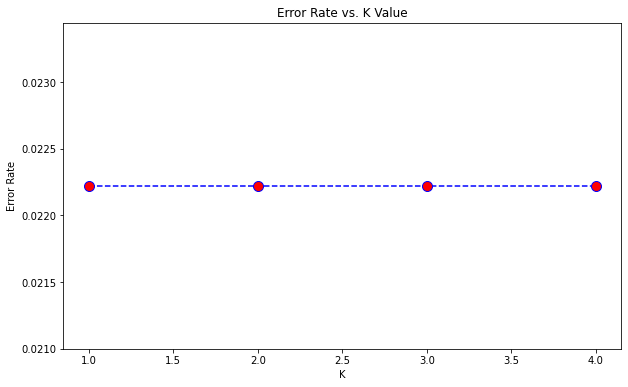

In [ ]:

error_rate = []# Will take some time
for i in range(1, X_train.shape[1]+1):
    print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,X_train.shape[1]+1),error_rate,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')